# Probabilistic Methods (Discrete)

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

### Wrangle

In [57]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [58]:
# Synthetic data to represent anomalous events
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [59]:
# Create size_mb to show size of file in megabytes
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp, utc=True)
df = df.set_index('timestamp')

In [60]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   request_path    13978 non-null  object 
 3   http_version    13978 non-null  object 
 4   status_code     13978 non-null  object 
 5   size            13978 non-null  int64  
 6   user_agent      13978 non-null  object 
 7   size_mb         13978 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 982.8+ KB


## Detecting Anomalies in Discrete Variables

- **count**: the number of times each unique value appears in the dataset
- **frequencies**: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [62]:
# Counts for each IP
df.ip.value_counts().head()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

In [63]:
# percentages of each IP
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64

In [64]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [65]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [66]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


From here we can find how many unique ip addresses there are:

In [67]:
ip_df['count'].sort_values().tail(5)

68.201.219.223       21
72.181.105.81       246
72.181.113.170      613
173.173.113.51     1059
97.105.19.58      11999
Name: count, dtype: int64

<AxesSubplot:>

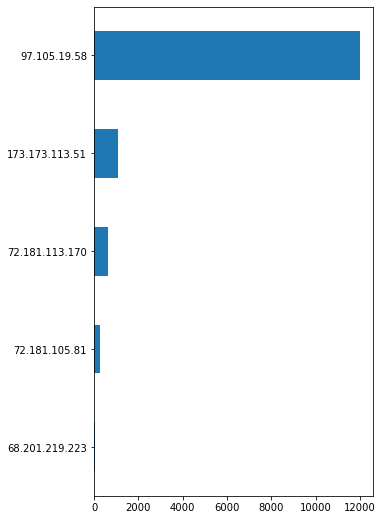

In [68]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

### Conditional Probabilities

In [69]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.sample(10)

,ip,status_code,proba_status_given_ip
22,97.105.19.58,200,0.998833
17,72.181.113.170,200,0.996737
13,54.172.14.223,200,1.000000
16,72.181.105.81,200,1.000000
19,95.31.16.121,301,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
21,97.105.15.120,301,1.000000
9,52.87.230.102,200,1.000000
8,45.23.250.16,200,1.000000


In [70]:
df[df.ip == '173.173.113.51']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 01:31:30+00:00,173.173.113.51,GET,/api/v1/sales,HTTP/1.1,200,493905,python-requests/2.21.0,0.471025
2019-04-17 01:31:56+00:00,173.173.113.51,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040
2019-04-17 01:31:59+00:00,173.173.113.51,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0,0.000332
2019-04-17 01:32:16+00:00,173.173.113.51,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-17 01:33:35+00:00,173.173.113.51,GET,/api/v1/sales,HTTP/1.1,200,493905,python-requests/2.21.0,0.471025
...,...,...,...,...,...,...,...,...
2019-04-17 05:20:01+00:00,173.173.113.51,GET,/api/v1/sales?page=179,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
2019-04-17 05:20:04+00:00,173.173.113.51,GET,/api/v1/sales?page=180,HTTP/1.1,200,510788,python-requests/2.21.0,0.487125
2019-04-17 05:20:07+00:00,173.173.113.51,GET,/api/v1/sales?page=181,HTTP/1.1,200,510317,python-requests/2.21.0,0.486676


In [71]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [72]:
df[df.ip == '72.181.113.170'].sort_values(by='status_code')

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:12:07+00:00,72.181.113.170,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-17 03:41:59+00:00,72.181.113.170,GET,/api/v1/sales?page=112,HTTP/1.1,200,510142,python-requests/2.21.0,0.486509
2019-04-17 03:42:01+00:00,72.181.113.170,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.487417
2019-04-17 03:42:03+00:00,72.181.113.170,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.487605
2019-04-17 03:42:05+00:00,72.181.113.170,GET,/api/v1/sales?page=115,HTTP/1.1,200,510140,python-requests/2.21.0,0.486507
...,...,...,...,...,...,...,...,...
2019-04-17 03:28:08+00:00,72.181.113.170,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.486859
2019-04-17 03:28:11+00:00,72.181.113.170,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.488865
2019-04-17 03:52:08+00:00,72.181.113.170,GET,/api/v1/sales?page=183,HTTP/1.1,200,308243,python-requests/2.21.0,0.293963


* Cases where the probability is < 100%
* Status codes other than 200

In [73]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


# Exercises

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [74]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [75]:
request_path_and_params = df.request_path.str.split('?', expand=True)
request_path_and_params.columns = ['request_path', 'request_params']
df = df.drop(columns='request_path').join(request_path_and_params)

In [76]:
df.head()

,ip,request_method,http_version,status_code,size,user_agent,size_mb,request_path,request_params
timestamp,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,/api/v1/sales,page=81
2019-04-16 19:34:42+00:00,97.105.19.58,GET,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,/api/v1/items,None
2019-04-16 19:34:42+00:00,97.105.19.58,GET,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,/api/v1/sales,page=81
2019-04-16 19:34:42+00:00,97.105.19.58,GET,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,/api/v1/items,None
2019-04-16 19:34:44+00:00,97.105.19.58,GET,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,/api/v1/sales,page=82


<AxesSubplot:title={'center':'Top 10 Most Commonly Requested Pages'}>

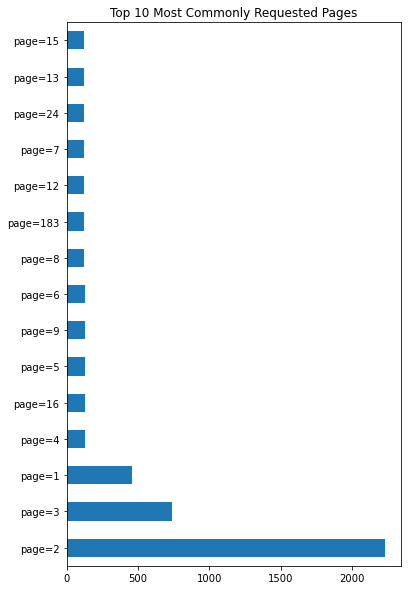

In [77]:
df.request_params.value_counts().head(15).plot.barh(
    figsize=(6,10),
    title='Top 10 Most Commonly Requested Pages',
)

In [78]:
df = df.tz_convert('America/Chicago')
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()

In [79]:
df.head(3)

,ip,request_method,http_version,status_code,size,user_agent,size_mb,request_path,request_params,hour,weekday
timestamp,,,,,,,,,,,
2019-04-16 14:34:42-05:00,97.105.19.58,GET,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,/api/v1/sales,page=81,14,Tuesday
2019-04-16 14:34:42-05:00,97.105.19.58,GET,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,/api/v1/items,None,14,Tuesday
2019-04-16 14:34:42-05:00,97.105.19.58,GET,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,/api/v1/sales,page=81,14,Tuesday


<AxesSubplot:title={'center':'Which hours are the most active?'}>

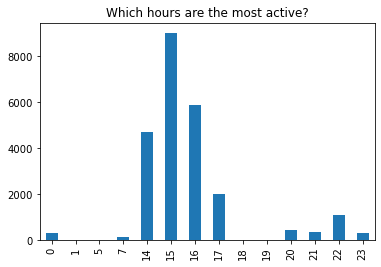

In [80]:
df.hour.value_counts().sort_index().plot.bar(title='Which hours are the most active?')

Afternoon appears to be the busiest time.

In [81]:
df.groupby('hour').request_params.value_counts(normalize=True).sort_values()

hour  request_params           
14    page=999                     0.000483
      page=99999999999999999998    0.000725
      page=79/                     0.000725
      page=666                     0.000967
      page=1                       0.001208
                                     ...   
23    page=3                       0.274611
      page=2                       0.326425
19    page=2                       0.500000
      page=3                       0.500000
1     page=1                       1.000000
Name: request_params, Length: 1619, dtype: float64

- Page 1 requests happen at 1
- Pages that don't exist were requested at 2 pm

In [82]:
df.groupby('request_params').hour.value_counts(normalize=True).sort_values()

request_params             hour
page=2                     7       0.000447
                           19      0.000895
page=3                     7       0.001357
                           19      0.002714
page=4                     23      0.007576
                                     ...   
page=0                     14      1.000000
page=666                   14      1.000000
page=999                   14      1.000000
page=79/                   14      1.000000
page=99999999999999999998  14      1.000000
Name: hour, Length: 1619, dtype: float64

In [83]:
df.groupby('weekday').request_params.value_counts(normalize=True)

weekday    request_params
Friday     page=79/          1.000000
Thursday   page=79/          1.000000
Tuesday    page=2            0.103214
           page=3            0.033179
           page=1            0.020077
                               ...   
Wednesday  page=95           0.002433
           page=96           0.002433
           page=97           0.002433
           page=98           0.002433
           page=99           0.002433
Name: request_params, Length: 373, dtype: float64

- On Friday and Thursday, only page 79 was requested
- Wednesday only had page requests for pages in the 90s